C:\Users\Ashutosh\AppData\Local\Temp\ipykernel_10448\3929279225.py:18: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ITSM_data.csv")
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashutosh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Training RandomForest...
RandomForest - Priority Accuracy: 0.6755
RandomForest - Department Accuracy: 0.7069

Training LogisticRegression...
LogisticRegression - Priority Accuracy: 0.6755
LogisticRegression - Department Accuracy: 0.7069

Training SVM...
SVM - Priority Accuracy: 0.6755
SVM - Department Accuracy: 0.7069

Best Performing Model: RandomForest

Issue: Outlook not syncing calendar events
Predicted Priority: 5.0
Predicted Department: application

Issue: Server memory overloaded in data center
Predicted Priority: 5.0
Predicted Department: application

Issue: Unable to connect to printer from SAP application
Predicted Priority: 5.0
Predicted Department: application


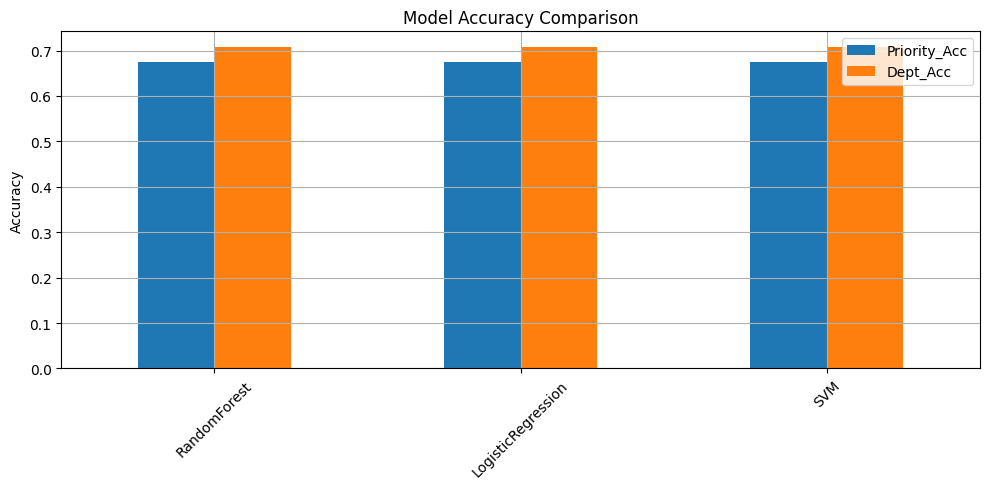

In [1]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

# Step 2: Load Dataset
df = pd.read_csv("ITSM_data.csv")

# Step 3: Drop rows with missing essential columns
df.dropna(subset=['Category', 'Priority', 'CI_Cat'], inplace=True)

# Step 4: Download stopwords for NLP preprocessing
nltk.download('stopwords')
from nltk.corpus import stopwords

# Text preprocessing function
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Step 5: Clean the text in the Category column
df['cleaned_text'] = df['Category'].apply(clean_text)

# Step 6: Encode the target variables
le_priority = LabelEncoder()
le_dept = LabelEncoder()
df['Priority_Label'] = le_priority.fit_transform(df['Priority'])
df['Dept_Label'] = le_dept.fit_transform(df['CI_Cat'])

# Step 7: Split Features and Targets
X = df['cleaned_text']
y = df[['Priority_Label', 'Dept_Label']]

# Step 8: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Define Classifiers (without LightGBM, XGBoost, Naive Bayes)
models = {
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True)
}

# Step 10: Train and Evaluate Each Model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=3000)),
        ('clf', MultiOutputClassifier(model))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc_priority = accuracy_score(y_test['Priority_Label'], y_pred[:, 0])
    acc_dept = accuracy_score(y_test['Dept_Label'], y_pred[:, 1])
    
    print(f"{name} - Priority Accuracy: {acc_priority:.4f}")
    print(f"{name} - Department Accuracy: {acc_dept:.4f}")
    
    results[name] = (acc_priority, acc_dept)

# Step 11: Select Best Performing Model
results_df = pd.DataFrame(results, index=['Priority_Acc', 'Dept_Acc']).T
best_model_name = results_df.mean(axis=1).idxmax()
print("\nBest Performing Model:", best_model_name)

# Step 12: Retrain Best Model on Full Data
final_model = models[best_model_name]
final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000)),
    ('clf', MultiOutputClassifier(final_model))
])
final_pipeline.fit(X, y)

# Step 13: Predict on Sample Tickets
sample_issues = [
    "Outlook not syncing calendar events",
    "Server memory overloaded in data center",
    "Unable to connect to printer from SAP application"
]

sample_cleaned = [clean_text(issue) for issue in sample_issues]
sample_preds = final_pipeline.predict(sample_cleaned)

pred_priorities = le_priority.inverse_transform(sample_preds[:, 0])
pred_departments = le_dept.inverse_transform(sample_preds[:, 1])

for issue, pri, dept in zip(sample_issues, pred_priorities, pred_departments):
    print(f"\nIssue: {issue}\nPredicted Priority: {pri}\nPredicted Department: {dept}")

# Step 14: Plot Accuracy Comparison
results_df.plot(kind='bar', figsize=(10, 5), title="Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
